# 🌬️ Wind turbines in Schleswig-Holstein

**Author:** Martin Brucker

**Student Number:** 942815

---

This notebook displays data from the wind turbines in Schleswig-Holstein, Germany. The data for this visual analysis are provided from the **OpenData Portal Schleswig-Holstein**, the data is provided by the **Landesamt für Umwelt** and is available under the following link: Windkraftanlagen 2023-10-11 https://opendata.schleswig-holstein.de/dataset/windkraftanlagen-2023-10-11.

The anthropogenic climate change is becoming a huge problem for our planet and society. 😢
This notebook gives a deeper understanding of the ongoing distribution of power plants by wind energy. 💡

In the beginning of the notebook, the data provided will be preprocessed to be in the right format for the later analysis. 📊
After that, a map of Schleswig-Holstein will be displayed that shows the municipalities that are contributing a lot of wind energy to the power network. 🗺️
After watching the map of Schleswig-Holstein, we are going to take a deeper look into the available and growing power provided by wind turbines in Schleswig-Holstein, which then brings us to a graph displaying the time difference between approval and start of operation. ⏱️

At the end, we are going to dive into the correlation between **Leistung**, **Narbenhöhe** and **Rotordurchmesser**. 🔬

# Data Acquisition and Processing

In [27]:
# Importing necessary libraries
import re
import pyproj
import numpy as np
import pandas as pd
import altair as alt
import geoplot as gplt
import geopandas as gpd
import geoplot.crs as gcrs
import matplotlib.pyplot as plt

In [28]:
# reading in data
windTurbine = pd.read_csv("data/opendata_wka_ib_gv_vb_sh_k_20231011.csv", sep=";")
gdf = gpd.GeoDataFrame.from_file("data/gemeinden_simplify20.geojson")

In [29]:
# convertig the NABENHOEHE, ROTORDURCHMESSER from string to float and replace the ',' with '.'
windTurbine["NABENHOEHE"] = windTurbine["NABENHOEHE"].str.replace(",", ".").astype(float)
windTurbine["ROTORDURCHMESSER"] = windTurbine["ROTORDURCHMESSER"].str.replace(",", ".").astype(float)

In [30]:
# transform inbetriebnahme to datetime dd.mm.yyyy
windTurbine["GENEHMIGT_AM"] = pd.to_datetime(windTurbine["GENEHMIGT_AM"], format="%d.%m.%Y")
windTurbine["INBETRIEBNAHME"] = pd.to_datetime(windTurbine["INBETRIEBNAHME"], format="%d.%m.%Y")
windTurbine["DATENDATUM"] = pd.to_datetime(windTurbine["DATENDATUM"], format="%d.%m.%Y")

In [31]:
# Define a function to convert the 'Schallleistungsspiegel' column to float
def convert_to_float(value):
    if pd.isnull(value):
        return np.nan
    
    # Use regular expression to find a pattern of digits followed by a comma and more digits
    match = re.search(r'\d+,\d+', value)
    
    if match:
        # Replace the comma with a dot and convert the value to float
        return float(match.group().replace(',', '.'))
    
    return np.nan

# Apply the 'convert_to_float' function to the 'SCHALLLEISTUNGSPEGEL' column
windTurbine['SCHALLLEISTUNGSPEGELConverted'] = windTurbine['SCHALLLEISTUNGSPEGEL'].apply(convert_to_float)

# Unfortunately, the 'SCHALLLEISTUNGSPEGEL' variable does not follow a specific standard,
# which makes transformation without manual intervention impossible, as 'DB' and 'HZ' are mixed up.


In [32]:
# The wind turbine with an 'Inbetriebnahme' date of 1996-04-01 looks suspicious since it is labeled as the type Tacke TW 600,
# but it shows that it produces 6000 kW, which is a lot for that date.
# After conducting research, it was found that the Tacke TW 600 actually has a power output of 600 kW.
# Therefore, we will correct the 'LEISTUNG' (power output) to 600 for Entry 2900.

#print(windTurbine[windTurbine["INBETRIEBNAHME"] == "1996-04-01"].head())

# Correct the 'LEISTUNG' (power output) to 600 for Entry 2900
windTurbine.loc[2900, "LEISTUNG"] = 600

In [33]:
# Calculate the yearly energy gain

# Extract the year from the 'INBETRIEBNAHME' column
windTurbine['Year'] = windTurbine['INBETRIEBNAHME'].dt.year

# Group by year and sum the 'LEISTUNG' column to get the total power output for each year
df_yearly = windTurbine.groupby('Year')['LEISTUNG'].sum().reset_index()

# Calculate the cumulative sum to get the total available energy up to each year
df_yearly['Cumulative_LEISTUNG'] = df_yearly['LEISTUNG'].cumsum()

# Calculate the newly added energy for each year
df_yearly['Added_LEISTUNG'] = df_yearly['Cumulative_LEISTUNG'].diff()

# For the first year, set the newly added energy equal to the total power output of that year
df_yearly.loc[df_yearly['Year'] == df_yearly['Year'].min(), 'Added_LEISTUNG'] = df_yearly.loc[df_yearly['Year'] == df_yearly['Year'].min(), 'LEISTUNG']


In [34]:
# Since there are few wind turbines with an inbetriebnahme (start of operation) date earlier than 1960,
# we are going to create a new dataframe for date analysis that excludes these turbines,
# as they are likely to be data errors or outliers.
windTurbineDate = windTurbine[windTurbine["INBETRIEBNAHME"] > "1960-01-01"]

# Additionally, there are turbines with a GENEHMIGT_AM (approval) date earlier than 1960,
# but with an inbetriebnahme date later than 1960.
# We are going to drop these turbines from the windTurbineDate dataframe.
windTurbineDate = windTurbineDate[windTurbineDate["GENEHMIGT_AM"] > "1960-01-01"]

In [35]:
# Convert the UTM coordinates to latitude and longitude using pyproj
def convert_coordinates(df, easting_col, northing_col):
    # Define the projections
    utm_proj = pyproj.Proj(proj='utm', zone=32, ellps='WGS84')  # UTM projection with zone 32 and WGS84 ellipsoid
    latlong_proj = pyproj.Proj(proj='latlong', datum='WGS84')  # Latitude and longitude projection with WGS84 datum

    # Create a transformer object to convert coordinates between projections
    transformer = pyproj.transformer.Transformer.from_proj(utm_proj, latlong_proj)

    # Apply the coordinate conversion to each row in the dataframe
    df['Longitude'], df['Latitude'] = transformer.transform(df[easting_col].values, df[northing_col].values)

    return df


# Convert the UTM coordinates in the windTurbine dataframe to latitude and longitude
windTurbine = convert_coordinates(windTurbine, 'OSTWERT', 'NORDWERT')

In [36]:
# Count the number of wind turbines per gemeinde (municipality)
turbine_counts = windTurbine['GEMEINDE'].value_counts().reset_index()
turbine_counts.columns = ['GEN', 'count']

# Merge the turbine counts with the geopandas dataframe
merged = gdf.set_index('GEN').join(turbine_counts.set_index('GEN'))

# Fill NA/NaN values in the 'count' column with 0
merged['count'] = merged['count'].fillna(0)

In [37]:
# Calculate the difference in days between the 'INBETRIEBNAHME' (start of operation) and 'GENEHMIGT_AM' (approval) dates
windTurbineDate['Time_Difference'] = (windTurbineDate['INBETRIEBNAHME'] - windTurbineDate['GENEHMIGT_AM']).dt.days

# Create a new column to store the year of approval
windTurbineDate['Year'] = windTurbineDate['GENEHMIGT_AM'].dt.year

# Visual Story

### Wind Turbine distribution in Schleswig-Holstein

The first chart provides a comprehensive view of the distribution of wind turbines across different Gemeinden in Schleswig-Holstein. It is represented by a map that is color-coded according to the number of wind turbines in each Gemeinde.

#### Key Observations:
- The map offers an initial overview of the overall distribution of wind turbines throughout Schleswig-Holstein.
- Contrary to popular media opinions, such as those expressed in [Bild Media](https://www.bild.de/regional/frankfurt/frankfurt-aktuell/7-windraeder-sollen-panorama-verschandeln-dorf-kaempft-gegen-windmuehlen-84007840.bild.html%29), wind turbines in Germany are not evenly distributed across the country, but rather clustered in certain regions with favorable wind conditions. This contradicts the common media narrative that wind turbines are spoiling the natural landscape everywhere. Therefore, the impact of wind turbines on the environment may not be as severe as some critics suggest.

#### Analysis:
The color gradient on the map ranges from light to dark, indicating the increasing number of wind turbines. This visual representation aids in quickly identifying areas with higher concentrations of wind turbines and those that are less populated with these energy-generating structures.


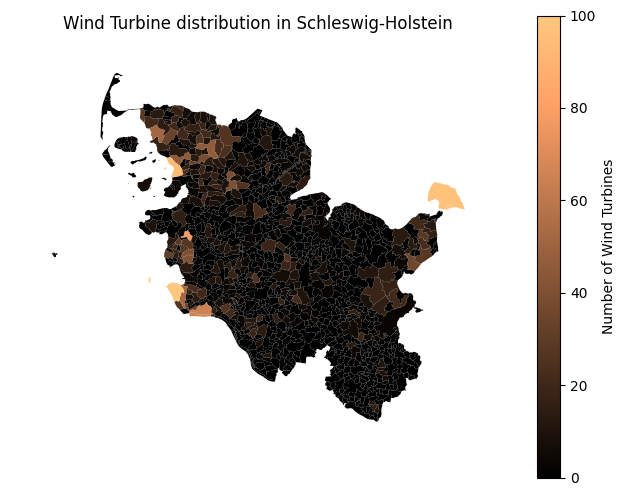

In [38]:
ax = gplt.choropleth(
    merged, hue='count', projection=gcrs.WebMercator(), 
    linewidth=0.5,
    cmap="copper",
    legend=True, legend_kwargs={'label': "Number of Wind Turbines"}
)

plt.title("Wind Turbine distribution in Schleswig-Holstein")
plt.show()


### Total Available Power per Year

This chart presents the total available wind energy power and the yearly added power production in Schleswig-Holstein from 1990 to 2023. The blue bars represent the total available power, while the red indicates yearly added power.

#### Key Observations

- A significant peak in newly added wind energy is observed in 2014 with 1.274 TW.
- There is a noticeable decline post-2014 until a resurgence in 2022.
- From 2020 onwards, positive growth trends are evident.

#### Analysis

The year 2014 marked a significant milestone due to technological or policy advancements favoring renewable energy sources. However, fluctuations post-2014 could be attributed to policy changes, technological advancements, or operational challenges faced by wind farms.

The resurgence in yearly added power from 2020 indicates increased efficiency of turbines or more favorable environmental policies. These fluctuations are crucial for future planning and investment into the wind energy sector to ensure sustainable and consistent growth.


In [39]:
# Create the Altair chart for total available energy
chart1 = alt.Chart(df_yearly).mark_bar().encode(
    x=alt.X('Year:O', title='Year of Operation'),
    y=alt.Y('Cumulative_LEISTUNG:Q', title='Total Power Available (in KW)'),
    color=alt.value('blue'),
    tooltip=['Year', 'Cumulative_LEISTUNG']
).properties(
    title='Total Available Power per Year'
)

# Create the Altair chart for newly added energy
chart2 = alt.Chart(df_yearly).mark_bar().encode(
    x='Year:O',
    y=alt.Y('Added_LEISTUNG:Q', title='Power Added Each Year (in KW)'),
    color=alt.value('red'),
    tooltip=['Year', 'Added_LEISTUNG']
)

# Combine the charts
chart = chart1 + chart2

# Add a legend
legend = alt.Legend(title="Power Type")
chart.encoding.color = alt.Color('Color:N', scale=None, legend=legend)

# Display the chart
chart


alt.LayerChart(...)

### Time Difference between Approval to First Energy Produced

The third chart displays the difference in approval to energy generation and the offset that it takes to bring a turbine into life.

#### Key Observations

- The delay in approval time differs strongly from year to year.
- 32 wind turbines have been taken into operation before approval but in comparison to the overall, it is a small part. I couldn't find hints with my research that the timestamps given are wrong.
- There is no noticeable trend of reduced time difference from approval to first energy produced over the years, indicating no improvement in efficiency.

### Analysis

This data visualization provides insights into the efficiency improvements and challenges faced over time. It underscores the need for streamlined processes and policies to reduce the time lag between project approval and actual energy production. The presence of outliers suggests potential areas for detailed investigation, aiming at policy refinement and process optimization.

In [40]:
# Create the boxplot
boxplot = alt.Chart(windTurbineDate).mark_boxplot().encode(
    x='Year:O',
    y=alt.Y('Time_Difference:Q', title='Time Difference (in days)'),
    tooltip=['Time_Difference']
)

# Create the mean point plot
mean = alt.Chart(windTurbineDate).mark_point(color='red', filled=True).encode(
    x='Year:O',
    y='mean(Time_Difference):Q'
)

# Combine the plots
chart = boxplot + mean

chart.properties(
    title='Boxplot of Time Difference from Approval to First Energy Produced Over the Years'
)


alt.LayerChart(...)

### Wind Turbine Performance by Height and Rotor Diameter

The scatter plot visualizes the relationship between the 'Nabenhohe', 'Rotordurchmesser' and 'Leistung' of wind turbines.

#### Key Observations

- There is a visible concentration of data points in the middle range of 'Nabenhohe', indicating that a significant number of turbines have moderate height and power output.
- Turbines with larger 'Rotordurchmesser' tend to have higher 'Leistung', suggesting that rotor diameter is positively correlated with power output.
- There is a wide distribution in the ‘Leistung’ at each level of ‘Nabenhohe’, indicating variability in power output among turbines of similar height.

### Analysis

This scatter plot aids in understanding the intricate dynamics between turbine height, rotor diameter, and power output. It highlights potential optimization opportunities for enhancing energy production efficiency. The diverse spread of data points underscores the complexity involved and indicates that multiple factors contribute to determining the optimal combination for maximum energy yield.


In [41]:
chart = alt.Chart(windTurbine).mark_circle(aspect=True).encode(
    x='NABENHOEHE',
    y='LEISTUNG',
    size='ROTORDURCHMESSER',
    color='ROTORDURCHMESSER',
    tooltip=['NABENHOEHE', 'ROTORDURCHMESSER', 'LEISTUNG']
).properties(
    width=400 ,
    height=400,
    title="Wind Turbine Performance by Height and Rotor Diameter"
).interactive()

chart


alt.Chart(...)

# Summary

This report presents the analysis of wind turbines in Schleswig-Holstein, a state in Germany with a high potential for wind energy production. The main findings are:

- The wind turbines are not evenly distributed across the state, but rather clustered in certain regions, as shown in the first plot.
- The total installed capacity of wind power has increased over the years, but with some fluctuations. The second plot shows that the annual growth rate was negative from 2014 to 2019, but positive since 2020.
- The approval process for new wind turbines is slow and inconsistent, as shown in the third plot. Some wind turbines started operating even before they were officially approved, while others had to wait for several years after the approval date.
- The size and power of wind turbines seem to correlate, as shown in the last plot. This suggests that building larger wind turbines could be a solution to generate more wind energy, but also poses some challenges such as environmental and social impacts.

## Limitations ❌

This analysis has some limitations that should be acknowledged:

- The data source, the OpenData Portal Schleswig-Holstein, has some quality issues, such as errors, inconsistencies, and missing values in some attributes. For example, some wind turbines have higher power values than their actual types, and some dates are not formatted correctly. 🙁
- The scope of the analysis is limited to Schleswig-Holstein, and does not provide a country-wide or global perspective on wind energy. Further research should also consider the general power generation and consumption patterns in Germany and beyond. ⚡
- The causal relationship between the approval process and the installed capacity of wind power is not clear, and requires more in-depth analysis. For example, it is not known how many wind turbines are currently in the pipeline, and how long they will take to be built and connected to the grid. 🏗️
- The impact of climate change on wind energy production is not addressed in this analysis, but it is an important factor to consider. Climate change may affect the wind patterns, the availability of land, and the demand for renewable energy sources. 🌍

## Future Work

Some possible directions for future work are:

- Predictive maintenance is a promising field that could benefit from data-driven approaches for wind turbines. This could involve creating a secure and standardized data exchange platform for wind turbine operators, manufacturers, and service providers, using International Data Spaces. This would enable better monitoring, diagnosis, and optimization of the operation and maintenance costs of wind turbines. 💻
- Stakeholder engagement is a crucial aspect of wind energy development, as it involves balancing the interests and concerns of various parties, such as landowners, communities, regulators, and investors. This could involve conducting surveys, interviews, and workshops to understand the perceptions, preferences, and expectations of different stakeholders, and to design participatory and inclusive decision-making processes. 🗣️
- Policy analysis is a useful tool to evaluate the effectiveness and efficiency of the existing and potential policies and regulations for wind energy. This could involve comparing the best practices and lessons learned from other countries and regions, and assessing the impacts and trade-offs of different policy options, such as subsidies, tariffs, quotas, and standards. 📜
